In [1]:
"""
Spam Data Extraction & EDA
"""

import os
import re

from pathlib import Path
from dataclasses import dataclass

import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split


@dataclass
class Config:
    """Constant config variables for notebook"""

    SEED = 42
    HOLDOUT_SIZE = 0.1


config = Config()


def mkdirs(path: Path):
    """Util to make directory


    Parameters
    ----------
    path : pathlib.Path
        Path object containing full file path
    """
    path.parent.mkdir(parents=True, exist_ok=True)

In [2]:
CURRENT_DIR = Path(os.path.dirname(os.path.realpath("__file__")))
PROJECT_ROOT = Path(CURRENT_DIR).parents[1]
SPAM_DATA_PATH = PROJECT_ROOT / Path("data/raw/1.0-spam-dataset/spam-dataset.csv")
SPLITS_PATH = PROJECT_ROOT / Path("data/interim/1.0-spam-dataset/splits")

In [3]:
df = (
    pd.read_csv(SPAM_DATA_PATH)
    .sample(frac=1, random_state=config.SEED)
    .reset_index(drop=True)
)
df.head()

Category                                            Message
0      ham  Squeeeeeze!! This is christmas hug.. If u lik ...
1      ham  And also I've sorta blown him off a couple tim...
2      ham  Mmm thats better now i got a roast down me! i...
3      ham      Mm have some kanji dont eat anything heavy ok
4      ham  So there's a ring that comes with the guys cos...

In [4]:
df.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [5]:
sample = df.sample(n=1, random_state=config.SEED).iloc[0]
print(f"Text : {sample.Message}\n")
print(f"Category : {sample.Category}")

Text : 0A$NETWORKS allow companies to bill for SMS, so they are responsible for their "suppliers", just as a shop has to give a guarantee on what they sell. B. G.

Category : spam


In [6]:
def make_splits(_df):
    """Make splits"""
    _df_train, _df_rest = train_test_split(
        _df,
        stratify=_df["Category"],
        test_size=2 * config.HOLDOUT_SIZE,
        random_state=config.SEED,
    )
    _df_val, _df_test = train_test_split(
        _df_rest, stratify=_df_rest["Category"], test_size=0.5, random_state=config.SEED
    )
    return (
        _df_train.reset_index(drop=True),
        _df_val.reset_index(drop=True),
        _df_test.reset_index(drop=True),
    )


df_train, df_val, df_test = make_splits(df)

In [7]:
len(df_train), len(df_val), len(df_test)

(4457, 557, 558)

  0%|          | 0/4457 [00:00<?, ?it/s]

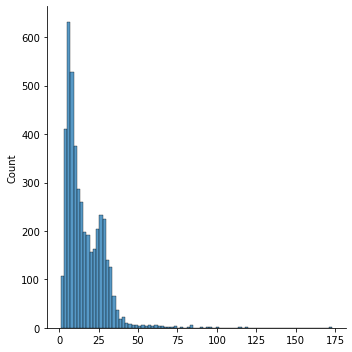

In [8]:
def clean_and_tokenize(text):
    """Cleans & splits on space"""
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text).lower()
    text = re.sub(r" +", " ", text).strip()
    return text.split(" ")


total_words = [
    len(clean_and_tokenize(df_train.loc[idx]["Message"]))
    for idx in tqdm(df_train.index)
]
sns.displot(total_words);

In [9]:
TRAIN_PATH = SPLITS_PATH / "train.csv"
VAL_PATH = SPLITS_PATH / "val.csv"
TEST_PATH = SPLITS_PATH / "test.csv"

mkdirs(TRAIN_PATH)

df_train.to_csv(TRAIN_PATH, index=False)
df_val.to_csv(VAL_PATH, index=False)
df_test.to_csv(TEST_PATH, index=False)